# Drought Network: Statistics
8.29.2022, a. stein

This notebook delves into comparing drought networks with a bit of a delve into graph theory.

In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import xarray as xr
import rioxarray
import rasterio as rio
import pandas as pd
import geopandas as gpd
import networkx as nx

import matplotlib.dates as mdates

from tqdm.autonotebook import tqdm

import sys
sys.path.append('../../')
import ndrought.wrangle as wrangle
import ndrought.compare as compare
import ndrought.plotting as ndplot
import ndrought.drought_network as dnet

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/tmp/ipykernel_1865282/2338660029.py:15: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
def tick(matrix):
    new_state = np.copy(matrix)

    i_dim, j_dim = matrix.shape

    for i in range(i_dim):
        for j in range(j_dim):
            north = matrix[i][j-1] if j>0 else 0
            south = matrix[i][j+1] if j<(j_dim-1) else 0
            west = matrix[i+1][j] if i<(i_dim-1) else 0
            east = matrix[i-1][j] if i>0 else 0
            se = matrix[i+1][j+1] if i<(i_dim-1) and j<(j_dim-1) else 0
            sw = matrix[i+1][j-1] if i<(i_dim-1) and j>0 else 0
            ne = matrix[i-1][j+1] if i>0 and j<(j_dim-1) else 0
            nw = matrix[i-1][j-1] if i>0 and j>0 else 0
            neighbors = np.sum([north, south, west, east, se, sw, ne, nw])

            # rules
            if matrix[i][j] == 0 and neighbors == 3: # reproduction
                new_state[i][j] = 1
            elif matrix[i][j] == 1 and neighbors < 2: # underpopulation
                new_state[i][j] = 0
            elif matrix[i][j] == 1 and neighbors > 3: # overpopulation
                new_state[i][j] = 0
            elif matrix[i][j] == 1 and neighbors == 2: # survives
                new_state[i][j] = 1
            elif matrix[i][j] == 1 and neighbors == 3: # also survives
                new_state[i][j] = 1

    return new_state

### 15x15 bounded grid (random)

In [3]:
ca_matrix_15x15 = np.zeros((15,15))

for i in np.arange(ca_matrix_15x15.shape[0]):
    for j in np.arange(ca_matrix_15x15.shape[1]):
        ca_matrix_15x15[i][j] = np.random.randint(2)

ca_matrix_15x15

array([[1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.],
       [0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1.],
       [0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 0., 1.],
       [1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1.],
       [1., 0., 1., 0., 0., 1., 1., 0., 1., 1., 1., 0., 0., 1., 0.],
       [0., 1., 0., 1., 1., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0.],
       [1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 0., 0., 1., 0., 0.],
       [1., 0., 1., 0., 1., 0., 0., 0., 1., 1., 1., 1., 0., 1., 0.],
       [0., 0., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1.],
       [0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 1., 1., 1., 1., 0.],
       [0., 1., 0., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 0., 0.],
       [1., 0., 1., 1., 0., 1., 1., 0., 1., 0., 0., 0., 1., 1., 0.],
       [1., 1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 1.],
       [1., 0., 1., 1., 1., 0., 1.

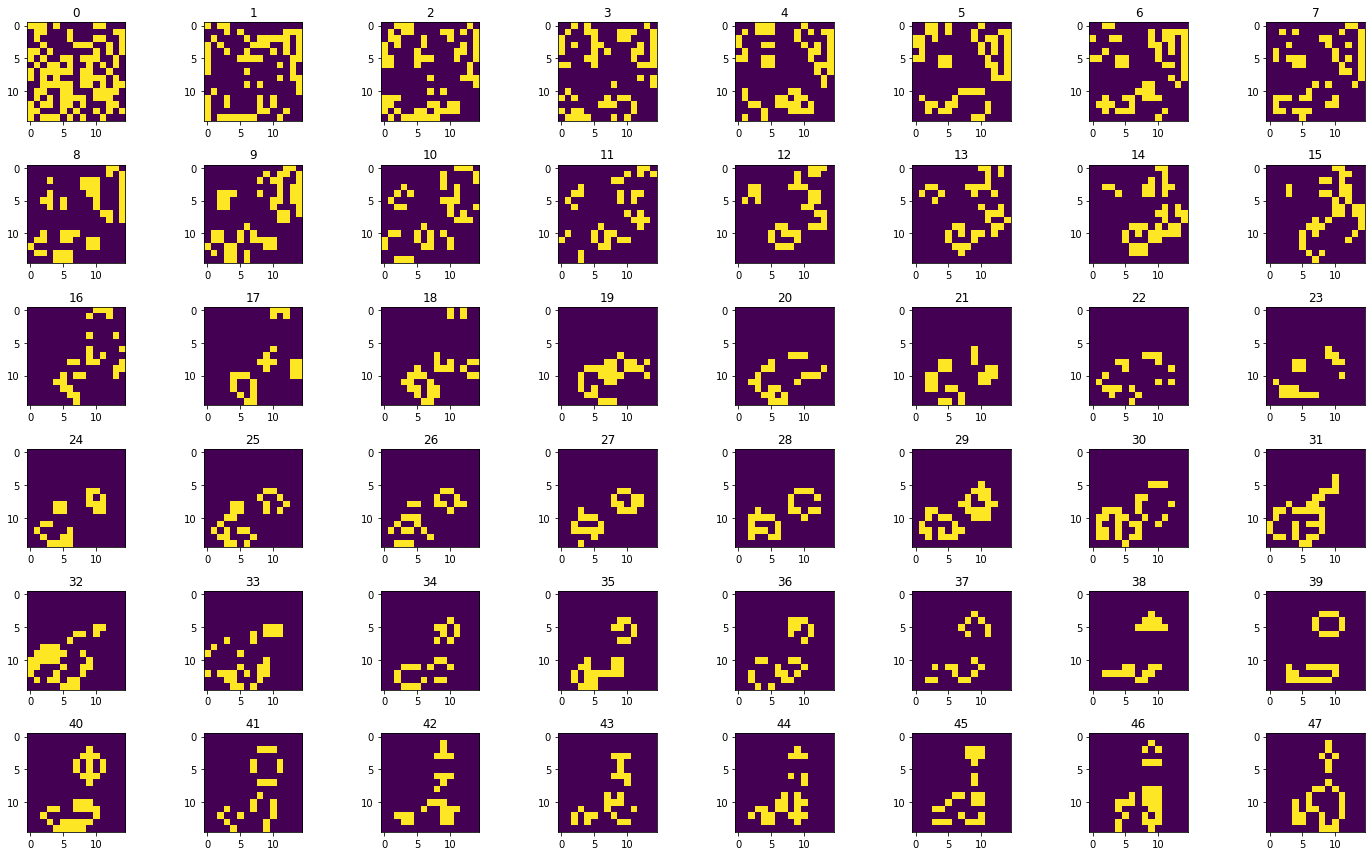

In [4]:
fig, axs = plt.subplots(6, 8, figsize=(20,12))

ca_series_15x15 = []
plot_matrix = ca_matrix_15x15

for i, ax in enumerate(axs.ravel()):
    ca_series_15x15.append(plot_matrix)
    ax.imshow(plot_matrix)
    plot_matrix = tick(plot_matrix)

    ax.set_title(i)

ca_series_15x15 = np.array(ca_series_15x15)

plt.tight_layout()

In [5]:
ca_net_15x15 = dnet.DroughtNetwork(ca_series_15x15, name="15x15 Cellular Automata")

  0%|          | 0/48 [00:00<?, ?it/s]

In [6]:
print(ca_net_15x15)

15x15 Cellular Automata: DroughtNetwork with D1 threshold, spawned 31-08-2022 11:47:02


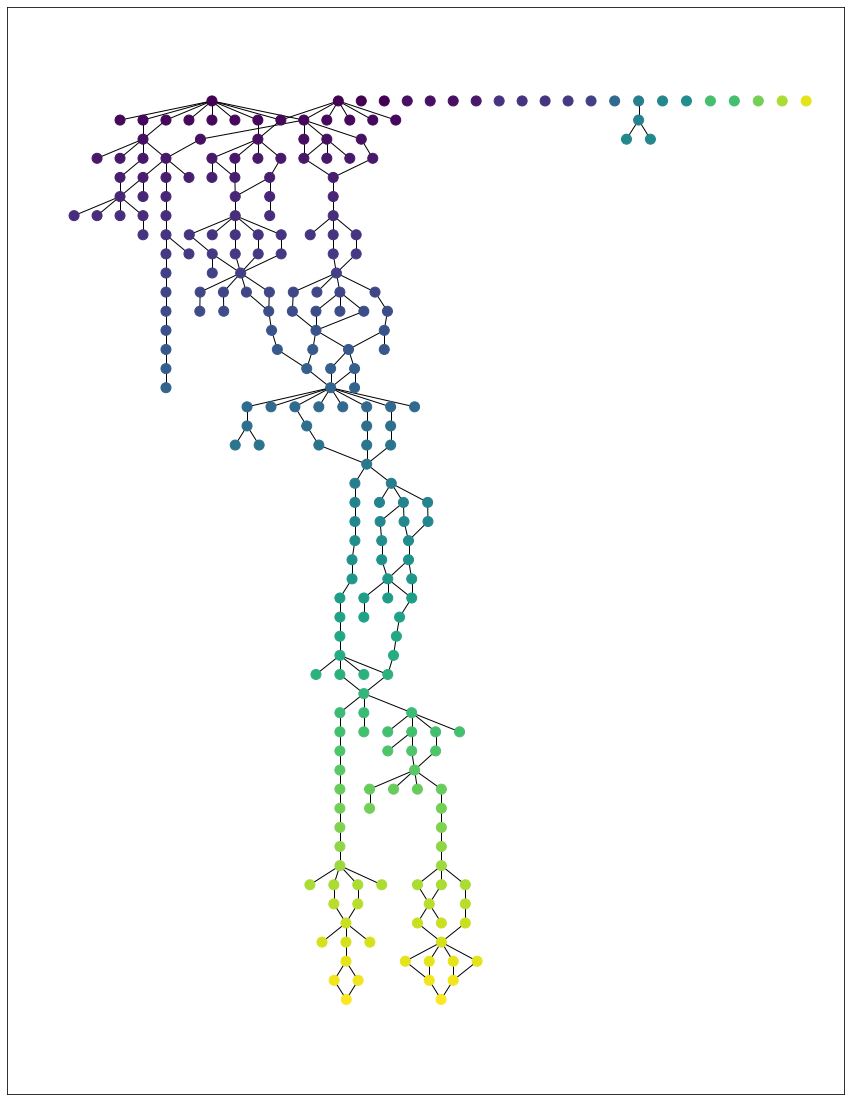

In [7]:
fig, ax = plt.subplots(figsize=(15,20))
topog, pos = ca_net_15x15.get_nx_network()

nx.draw_networkx(topog, pos, ax=ax, node_size=100, with_labels=False, node_color=ca_net_15x15.temporal_color_map(cmap=plt.cm.get_cmap('viridis')))

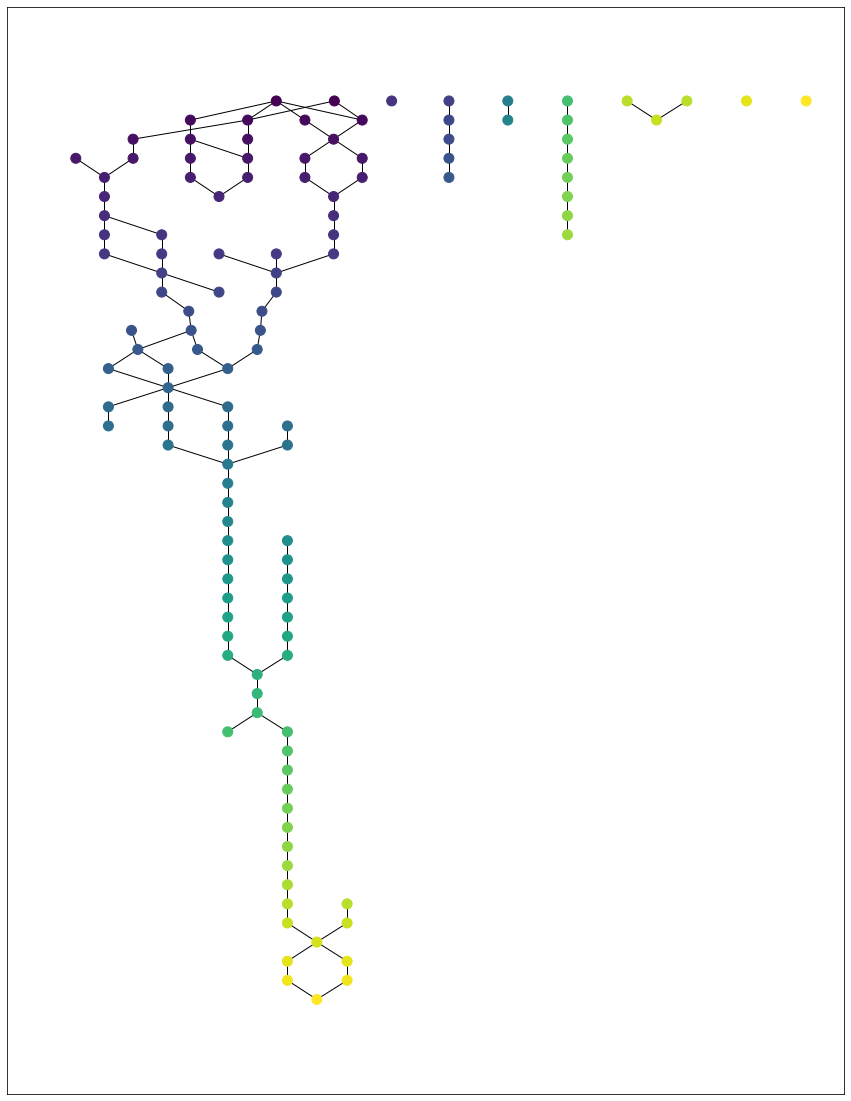

In [9]:
fig, ax = plt.subplots(figsize=(15,20))

adj_dict = ca_net_15x15.filter_adj_dict_by_area(4)
topog, pos = ca_net_15x15.get_nx_network(adj_dict=adj_dict)
color_map = ca_net_15x15.temporal_color_map(adj_dict=adj_dict, cmap=plt.cm.get_cmap('viridis'))

nx.draw_networkx(topog, pos, ax=ax, node_size=100, with_labels=False, node_color=color_map)